In [ ]:
!pip install tensorflow_addons

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import pandas as pd
import cv2
from keras.utils import to_categorical
import os
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import *
warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

from tensorflow import einsum
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras import Sequential
import tensorflow.keras.layers as nn

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


TensorFlow Version 2.12.0


#VIT

In [ ]:
!unzip '/content/drive/MyDrive/data/data.zip' -d '/'

In [5]:
INPUT_PATH = '/content/data'
EMOTIONS = ["happy","sad"]
IMAGE_SIZE = (96, 96)

def image_generator(input_path, emotions, image_size):
    for index, emotion in enumerate(emotions):
        for filename in os.listdir(os.path.join(input_path, emotion)):
            img = cv2.imread(os.path.join(input_path, emotion, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, image_size)
            #img = img.astype('float32') / 255.0  # Normilize
            yield img, index

def load_images(input_path, emotions, image_size):
    X, y = [], []
    for img, label in image_generator(input_path, emotions, image_size):
        X.append(img)
        y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [6]:
X, y = load_images(INPUT_PATH,EMOTIONS, IMAGE_SIZE)
input_shape = X[0].shape

In [7]:
np.random.seed(11)
id_pos = np.where(y == 1)[0]
id_neg = np.where(y == 0)[0]

np.random.shuffle(id_pos)
np.random.shuffle(id_neg)

id_train_neg = id_neg[:int(len(id_neg) * 0.7)]
id_train_pos = id_pos[:int(len(id_pos) * 0.7)]
id_train = np.concatenate((id_train_neg, id_train_pos), axis = 0)

id_val_neg = id_neg[int(len(id_neg) * 0.7):int(len(id_neg) * 0.9)]
id_val_pos = id_pos[int(len(id_pos) * 0.7):int(len(id_pos) * 0.9)]
id_val = np.concatenate((id_val_neg, id_val_pos), axis = 0)

id_test_neg = id_neg[int(len(id_neg) * 0.9):]
id_test_pos = id_pos[int(len(id_pos) * 0.9):]
id_test = np.concatenate((id_test_neg, id_test_pos), axis = 0)

In [8]:
#train
x_train = X[id_train]
y_train = y[id_train]
#val
x_val = X[id_val]
y_val = y[id_val]
#test
x_test = X[id_test]
y_test = y[id_test]

y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (8272, 96, 96, 3) - y_train shape: (8272, 1)
x_val shape: (2363, 96, 96, 3) - y_val shape: (2363, 1)
x_test shape: (1183, 96, 96, 3) - y_test shape: (1183, 1)


In [9]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 96//2  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [10]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 48 X 48
Patch size: 6 X 6
Patches per image: 64
Elements per patch: 108


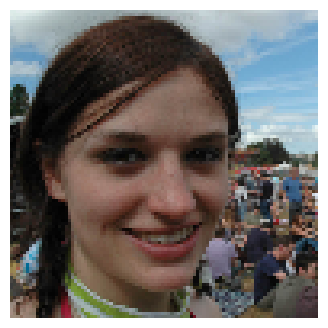

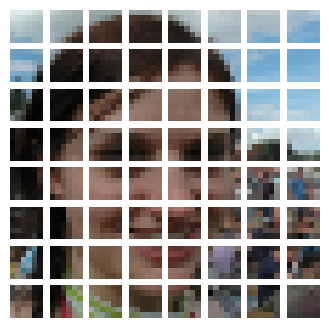

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Tạo một ImageDataGenerator object và cấu hình các phép biến đổi
datagen = ImageDataGenerator(
    rotation_range=20,  # xoay ảnh từ -20 đến +20 độ
    width_shift_range=0.2,  # dịch chuyển theo chiều ngang từ -20% đến +20% của kích thước ảnh
    height_shift_range=0.2,  # dịch chuyển theo chiều dọc từ -20% đến +20% của kích thước ảnh
    horizontal_flip=True  # lật ảnh theo chiều ngang
)

# Fit data generator cho dữ liệu huấn luyện
datagen.fit(x_train)

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [14]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        projecttion = self.projection(patch)
        position_embedding = self.position_embedding(positions)
        encoded = projecttion + position_embedding
        return encoded

In [15]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.BatchNormalization()(x)
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [16]:
'''
This part takes images as inputs,
Conv layer filter matches query dim of multi-head attention layer 
Add embeddings by randomly initializing the weights
'''

def generate_patch_conv_orgPaper_f(patch_size, hidden_size, inputs):
  patches = layers.Conv2D(filters=hidden_size, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
  row_axis, col_axis = (1, 2) # channels last images
  seq_len = (inputs.shape[row_axis] // patch_size) * (inputs.shape[col_axis] // patch_size)
  x = tf.reshape(patches, [-1, seq_len, hidden_size])
  return x

### Positonal Encoding Layer

class AddPositionEmbs(layers.Layer):
  """inputs are image patches 
  Custom layer to add positional embeddings to the inputs."""

  def __init__(self, posemb_init=None, **kwargs):
    super().__init__(**kwargs)
    self.posemb_init = posemb_init
    #posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02), name='posembed_input') # used in original code

  def build(self, inputs_shape):
    pos_emb_shape = (1, inputs_shape[1], inputs_shape[2])
    self.pos_embedding = self.add_weight('pos_embedding', pos_emb_shape, initializer=self.posemb_init)

  def call(self, inputs, inputs_positions=None):
    # inputs.shape is (batch_size, seq_len, emb_dim).
    pos_embedding = tf.cast(self.pos_embedding, inputs.dtype)

    return inputs + pos_embedding

pos_embed_layer = AddPositionEmbs(posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02))  

In [17]:
def create_vit_classifier():
    inputs = layers.Input(shape = x_train.shape[1:])
    # Augment data.
    augmented = data_augmentation(inputs)

    # Create patches.
    patches = generate_patch_conv_orgPaper_f(patch_size, projection_dim, augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(1, activation='sigmoid')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [18]:
def create_vit_classifier_cross():
    inputs = layers.Input(shape = x_train.shape[1:])
    # Augment data.
    augmented = data_augmentation(inputs)
    small_patch_size = 6
    large_patch_size = 12

    # Create patches.
    patches_small = generate_patch_conv_orgPaper_f(small_patch_size, projection_dim, augmented)
    patches_large = generate_patch_conv_orgPaper_f(large_patch_size, projection_dim, augmented)

    num_patches_small = (image_size // small_patch_size) ** 2
    num_patches_large = (image_size // large_patch_size) ** 2
    # Encode patches.
    encoded_patches_small = PatchEncoder(num_patches_small, projection_dim)(patches_small)
    encoded_patches_large = PatchEncoder(num_patches_large, projection_dim)(patches_large)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1_small = layers.LayerNormalization(epsilon=1e-6)(encoded_patches_small)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1_small, x1_small)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches_small])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches_small = layers.Add()([x3, x2])

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1_large = layers.LayerNormalization(epsilon=1e-6)(encoded_patches_large)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1_large, x1_large)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches_large])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches_large = layers.Add()([x3, x2])
    
    dim_k = 64
    dim_v = 64
    dense_q = tf.keras.layers.Dense(units=dim_k)
    dense_k = tf.keras.layers.Dense(units=dim_k)
    dense_v = tf.keras.layers.Dense(units=dim_v)
    queries = dense_q(encoded_patches_small)
    keys = dense_k(encoded_patches_large)
    values = dense_v(encoded_patches_large)
    cross_attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=0.1
    )(query=queries, value=values, key=keys)

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(cross_attention_output)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(1, activation = 'sigmoid')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [19]:
#Run Example with early stoping and calculate f1 score
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def run_experiment(model, x_train, y_train,x_val, y_val, x_test, y_test, datagen_bool, datagen):
  
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
            f1_m
        ],
    )

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

    if datagen_bool == True:
      history = model.fit(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        callbacks=[callback],
    )
    else:
      history = model.fit(
          x=x_train,
          y=y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          validation_data=(x_val, y_val),
          callbacks=[callback],
      )

    _, accuracy, f1_score = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test F1 score: {round(f1_score * 100, 2)}%")

    return history

In [20]:
np.set_printoptions(precision=4)

In [ ]:
vit_classifier = create_vit_classifier_cross()
history = run_experiment(vit_classifier,x_train, y_train,x_val, y_val, x_test, y_test, datagen_bool = False, datagen = datagen)
y_pred = vit_classifier.predict(x_test)
print(classification_report(y_test, np.round(y_pred)))

Epoch 1/100
33/33 [==============================] - 44s 357ms/step - loss: 0.8014 - accuracy: 0.6717 - f1_m: 0.6027 - val_loss: 1.5187 - val_accuracy: 0.7215 - val_f1_m: 0.2854
Epoch 2/100
33/33 [==============================] - 9s 260ms/step - loss: 0.4113 - accuracy: 0.8405 - f1_m: 0.8051 - val_loss: 1.0692 - val_accuracy: 0.8409 - val_f1_m: 0.3955
Epoch 3/100
33/33 [==============================] - 8s 250ms/step - loss: 0.2687 - accuracy: 0.8936 - f1_m: 0.8705 - val_loss: 0.7317 - val_accuracy: 0.8870 - val_f1_m: 0.4374
Epoch 4/100
33/33 [==============================] - 9s 260ms/step - loss: 0.2441 - accuracy: 0.9039 - f1_m: 0.8846 - val_loss: 1.5182 - val_accuracy: 0.8557 - val_f1_m: 0.4188
Epoch 5/100
33/33 [==============================] - 9s 260ms/step - loss: 0.2056 - accuracy: 0.9313 - f1_m: 0.9188 - val_loss: 0.2539 - val_accuracy: 0.9382 - val_f1_m: 0.4696
Epoch 6/100
33/33 [==============================] - 8s 235ms/step - loss: 0.1776 - accuracy: 0.9375 - f1_m: 0.923

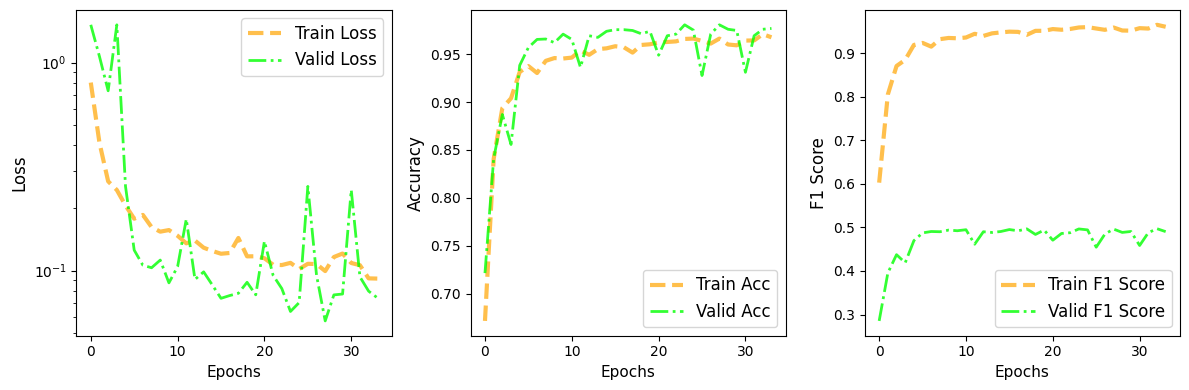

In [ ]:
### Plot train and validation curves
history = history.history
loss = history['loss']
v_loss = history['val_loss']

acc = history['accuracy'] 
v_acc = history['val_accuracy']

f1_score = history['f1_m']
val_f1_score = history['val_f1_m']
epochs = range(len(loss))

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.yscale('log')
plt.plot(epochs, loss, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Loss')
plt.plot(epochs, v_loss, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Loss')
# plt.ylim(0.3, 100)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 3, 2)
plt.plot(epochs, acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Acc')
plt.plot(epochs, v_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 3, 3)
plt.plot(epochs, f1_score, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train F1 Score')
plt.plot(epochs, val_f1_score, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid F1 Score') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [22]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier,x_train, y_train,x_val, y_val, x_test, y_test, datagen_bool = False, datagen = datagen)
y_pred = vit_classifier.predict(x_test)
print(classification_report(y_test, np.round(y_pred)))

Epoch 1/100
33/33 [==============================] - 24s 277ms/step - loss: 0.4767 - accuracy: 0.8236 - f1_m: 0.7884 - val_loss: 0.2973 - val_accuracy: 0.9289 - val_f1_m: 0.4736
Epoch 2/100
33/33 [==============================] - 6s 174ms/step - loss: 0.2857 - accuracy: 0.8987 - f1_m: 0.8787 - val_loss: 0.2400 - val_accuracy: 0.9340 - val_f1_m: 0.4758
Epoch 3/100
33/33 [==============================] - 6s 176ms/step - loss: 0.2199 - accuracy: 0.9228 - f1_m: 0.9081 - val_loss: 0.1769 - val_accuracy: 0.9429 - val_f1_m: 0.4793
Epoch 4/100
33/33 [==============================] - 6s 177ms/step - loss: 0.1694 - accuracy: 0.9379 - f1_m: 0.9255 - val_loss: 0.1016 - val_accuracy: 0.9628 - val_f1_m: 0.4919
Epoch 5/100
33/33 [==============================] - 6s 174ms/step - loss: 0.1488 - accuracy: 0.9473 - f1_m: 0.9367 - val_loss: 0.0980 - val_accuracy: 0.9674 - val_f1_m: 0.4877
Epoch 6/100
33/33 [==============================] - 6s 181ms/step - loss: 0.1399 - accuracy: 0.9495 - f1_m: 0.940

# Pretrained

In [ ]:
!pip install --quiet vit-keras

from vit_keras import vit

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
Image_size = 224  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
vit_model = vit.vit_b32(
        image_size = Image_size,
        activation = 'sigmoid',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(Image_size, Image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
vit_model.trainable = False

In [ ]:
model = tf.keras.Sequential([
        data_augmentation,
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(20, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 224, 224, 3)      7         
 al)                                                             
                                                                 
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_34 (Bat  (None, 768)              3072      
 chNormalization)                                                
                                                                 
 dense_40 (Dense)            (None, 20)                15380     
                                                                 
 batch_normalization_35 (Bat  (None, 20)        

In [ ]:
history_pretrained = run_experiment(model,x_train, y_train,x_val, y_val, x_test, y_test, datagen_bool = False, datagen = datagen)

In [ ]:
y_pred = model.predict(x_test)
print(classification_report(y_test, np.round(y_pred)))

37/37 [==============================] - 8s 121ms/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       691
           1       0.98      0.94      0.96       492

    accuracy                           0.97      1183
   macro avg       0.97      0.97      0.97      1183
weighted avg       0.97      0.97      0.97      1183



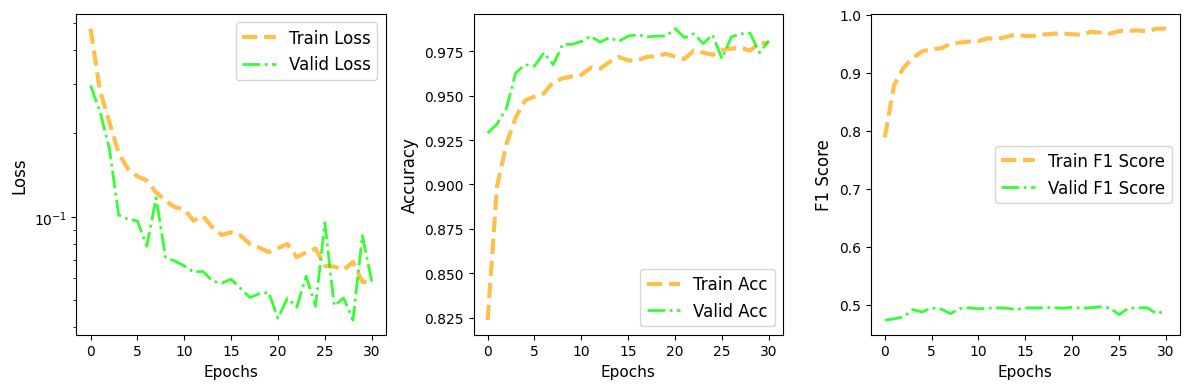

In [23]:
### Plot train and validation curves
history = history.history
loss = history['loss']
v_loss = history['val_loss']

acc = history['accuracy'] 
v_acc = history['val_accuracy']

f1_score = history['f1_m']
val_f1_score = history['val_f1_m']
epochs = range(len(loss))

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.yscale('log')
plt.plot(epochs, loss, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Loss')
plt.plot(epochs, v_loss, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Loss')
# plt.ylim(0.3, 100)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 3, 2)
plt.plot(epochs, acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Acc')
plt.plot(epochs, v_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 3, 3)
plt.plot(epochs, f1_score, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train F1 Score')
plt.plot(epochs, val_f1_score, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid F1 Score') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

#Image Generator

In [24]:
vit_classifier = create_vit_classifier_cross()
history = run_experiment(vit_classifier,x_train, y_train,x_val, y_val, x_test, y_test, datagen_bool = True, datagen = datagen)
y_pred = vit_classifier.predict(x_test)
print(classification_report(y_test, np.round(y_pred)))

Epoch 1/100
33/33 [==============================] - 57s 790ms/step - loss: 1.0193 - accuracy: 0.5331 - f1_m: 0.4201 - val_loss: 1.1986 - val_accuracy: 0.5264 - val_f1_m: 0.3389
Epoch 2/100
33/33 [==============================] - 24s 718ms/step - loss: 0.8750 - accuracy: 0.5392 - f1_m: 0.4093 - val_loss: 1.0659 - val_accuracy: 0.4837 - val_f1_m: 0.4422
Epoch 3/100
33/33 [==============================] - 22s 674ms/step - loss: 0.7851 - accuracy: 0.5516 - f1_m: 0.4220 - val_loss: 0.8355 - val_accuracy: 0.5679 - val_f1_m: 0.2956
Epoch 4/100
33/33 [==============================] - 22s 651ms/step - loss: 0.7183 - accuracy: 0.5852 - f1_m: 0.4331 - val_loss: 0.7823 - val_accuracy: 0.5489 - val_f1_m: 0.3498
Epoch 5/100
33/33 [==============================] - 24s 719ms/step - loss: 0.6879 - accuracy: 0.5972 - f1_m: 0.4359 - val_loss: 0.7967 - val_accuracy: 0.5370 - val_f1_m: 0.4455
Epoch 6/100
33/33 [==============================] - 21s 656ms/step - loss: 0.6548 - accuracy: 0.6226 - f1_m: 

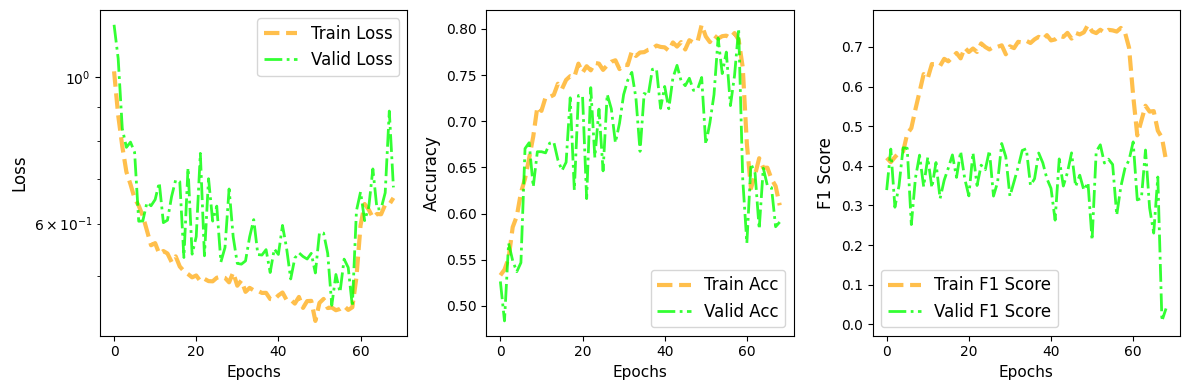

In [25]:
### Plot train and validation curves
history = history.history
loss = history['loss']
v_loss = history['val_loss']

acc = history['accuracy'] 
v_acc = history['val_accuracy']

f1_score = history['f1_m']
val_f1_score = history['val_f1_m']
epochs = range(len(loss))

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.yscale('log')
plt.plot(epochs, loss, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Loss')
plt.plot(epochs, v_loss, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Loss')
# plt.ylim(0.3, 100)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 3, 2)
plt.plot(epochs, acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Acc')
plt.plot(epochs, v_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 3, 3)
plt.plot(epochs, f1_score, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train F1 Score')
plt.plot(epochs, val_f1_score, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid F1 Score') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()